# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

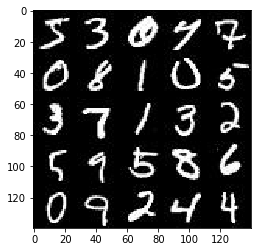

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

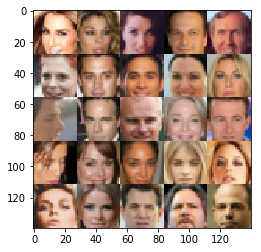

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\eg

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
             filters = filters, 
             kernel_size = 3, 
             strides = 1,
             padding="same")
        x = tf.concat([images,tf.contrib.keras.layers.LeakyReLU(alpha)(x)],3)
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    init_dim =[-1,7,7,512]
    init_len = 7*7*512
    filters = 512
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')

            x = tf.layers.batch_normalization(x, training = is_train)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 3,
                                   strides = 1,
                                   padding = 'same')
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:2*learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 1, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0130... Generator Loss: 5.6779
Epoch 1/2... Discriminator Loss: 0.0048... Generator Loss: 6.8777
Epoch 1/2... Discriminator Loss: 0.0549... Generator Loss: 3.3604
Epoch 1/2... Discriminator Loss: 0.0276... Generator Loss: 4.5982
Epoch 1/2... Discriminator Loss: 3.2179... Generator Loss: 13.7242
Epoch 1/2... Discriminator Loss: 2.6953... Generator Loss: 0.3974
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 3.2761
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 2.6689
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 1.6007
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 1.8644


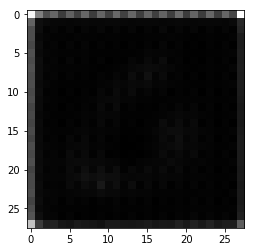

Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 1.9564
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.2456
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 1.2696
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.5529
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 0.9630


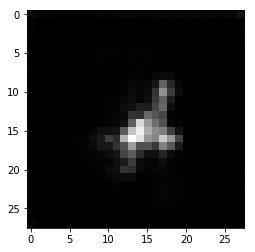

Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.5854
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 2.6086
Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.8957
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.0997


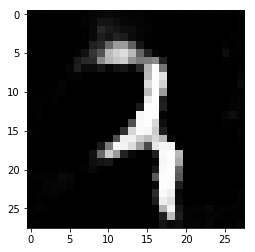

Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.5856
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 1.6356
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.2470
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.8008
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 0.6707


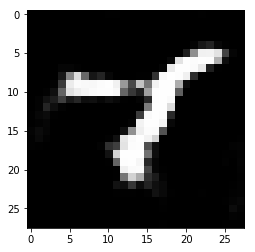

Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.4383
Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 2.9290... Generator Loss: 3.9492
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.3430
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.6469


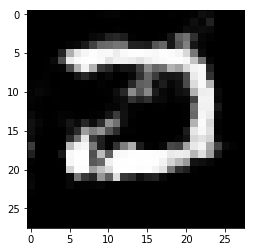

Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 0.6107
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.1388
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 0.8787


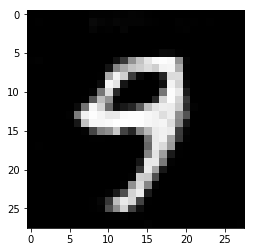

Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.1810
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 1.3633
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 0.5640... Generator Loss: 1.8407
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 0.9991


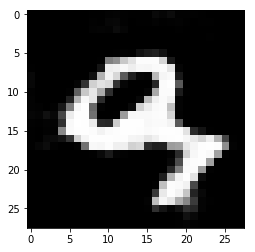

Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.3945
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 0.2893... Generator Loss: 2.0461
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 2.5291
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 0.9922


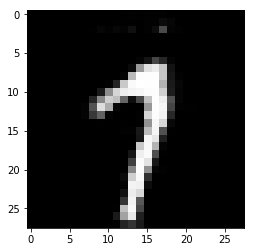

Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 0.4506... Generator Loss: 1.6633
Epoch 2/2... Discriminator Loss: 2.0028... Generator Loss: 0.2479
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.4413
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 1.7190... Generator Loss: 3.4075
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 1.8608
Epoch 2/2... Discriminator Loss: 0.9680... Generator Loss: 0.6859


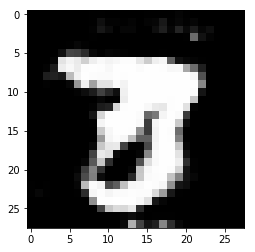

Epoch 2/2... Discriminator Loss: 1.0725... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 2.7673
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.0345


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.7800
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 2.4440
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.9434... Generator Loss: 0.2034


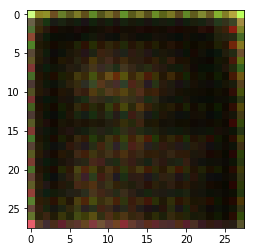

Epoch 1/1... Discriminator Loss: 1.9617... Generator Loss: 5.3019
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 2.2926
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 2.8267
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 4.3381
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 1.7886


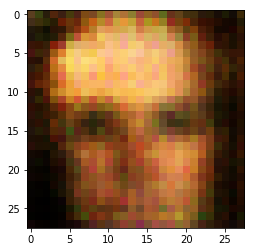

Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 4.9498
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 2.3805
Epoch 1/1... Discriminator Loss: 2.0242... Generator Loss: 0.2169
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 1.7334
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 2.8921
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 2.3152
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 2.6963
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 2.4298


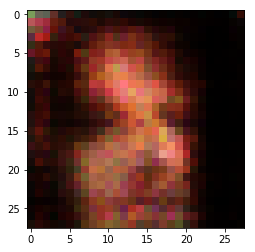

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 3.2783
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 4.1381
Epoch 1/1... Discriminator Loss: 1.8044... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.9068
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 0.3024


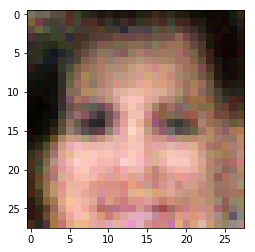

Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 2.2348
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 2.2052
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 4.3207
Epoch 1/1... Discriminator Loss: 2.3572... Generator Loss: 0.1295
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 2.0933
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 2.8996


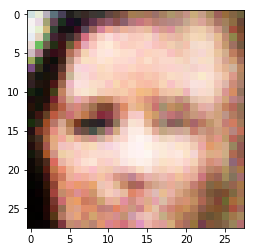

Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 2.0400
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 2.5259
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.0823


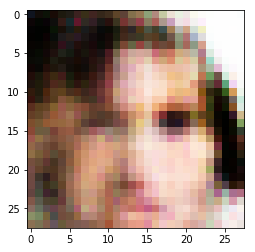

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.9925
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 2.3541
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 2.2980
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 2.9013
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 2.4428
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 3.3936
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 2.5510


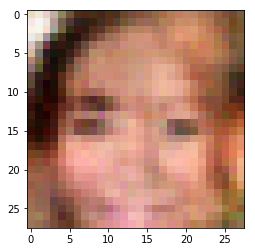

Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 3.1428
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 3.9546
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 2.6913
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.5533


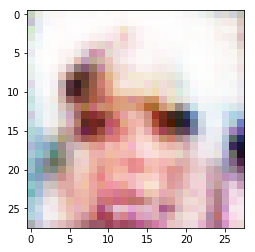

Epoch 1/1... Discriminator Loss: 2.0665... Generator Loss: 0.1873
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 2.1851
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 2.3430
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 4.9312
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.4742
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 3.5859
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.0222


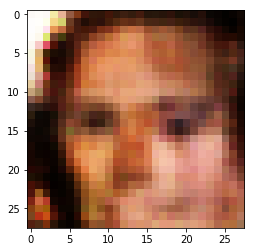

Epoch 1/1... Discriminator Loss: 2.6701... Generator Loss: 2.1827
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 2.2029
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.0369
Epoch 1/1... Discriminator Loss: 0.2667... Generator Loss: 2.3179
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 1.8390
Epoch 1/1... Discriminator Loss: 2.1435... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.2568... Generator Loss: 4.9974
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.0905


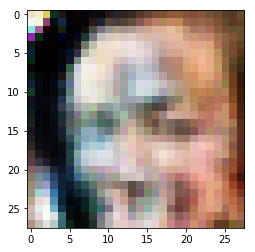

Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 4.1443
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 1.7055
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 4.1995
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 3.0876
Epoch 1/1... Discriminator Loss: 0.2891... Generator Loss: 2.1814
Epoch 1/1... Discriminator Loss: 0.2192... Generator Loss: 4.3371
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.1844


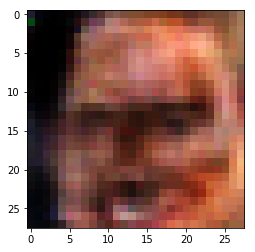

Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 1.3215
Epoch 1/1... Discriminator Loss: 1.8042... Generator Loss: 9.0866
Epoch 1/1... Discriminator Loss: 0.3145... Generator Loss: 2.0639
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 4.2789
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 4.9008
Epoch 1/1... Discriminator Loss: 1.9680... Generator Loss: 4.5503
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 4.1150
Epoch 1/1... Discriminator Loss: 0.2988... Generator Loss: 2.8255
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.0671... Generator Loss: 4.3058


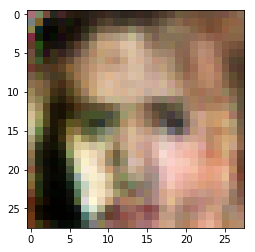

Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.3076... Generator Loss: 2.6551
Epoch 1/1... Discriminator Loss: 3.2157... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.2484... Generator Loss: 3.5648
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 1.8497
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 1.9967


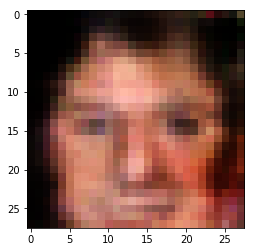

Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 3.5579
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 2.0907
Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 2.8353... Generator Loss: 2.2155
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 3.1892
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 3.7715
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 4.7300
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 3.4348


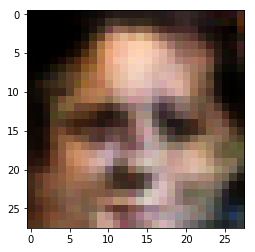

Epoch 1/1... Discriminator Loss: 0.2517... Generator Loss: 2.0818
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 4.3796
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 2.0792
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 3.6249
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.8049


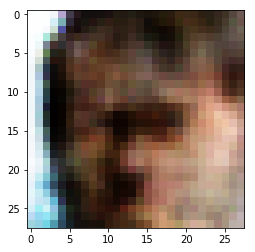

Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 1.8843
Epoch 1/1... Discriminator Loss: 2.8137... Generator Loss: 0.2788
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.0311
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 2.4670
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 4.8988


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.